In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
from IPython.display import display, Latex

from torch.distributions.multivariate_normal import MultivariateNormal
from datetime import datetime

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class Linear_NN(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: hidden layer dimension 
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.lin_out = nn.Linear(m, k, bias=False)
        self.lin_in = nn.Linear(d, m, bias=False)
        
        self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        
    def forward(self, xb):
        xb = self.lin_in(xb)
        
        for i in range(self.L):
            xb = self.lin_hidden[i](xb)
            
        xb = self.lin_out(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

## L-hidden linear layer

- L-hidden layer with same hidden width $m > \max\{d,k\}$

- input covariance $\sum_{i=1}^{n} x_ix_i^T = \Sigma_{xx} = I$

**First approximation of the outer product Hessian (Eq. (56), (57))**

\begin{align}
    \lambda_{\max}(\hat{\mathbf{H}}_O) &\leq \sum_{\ell=1}^L \lambda_{\max}(\mathbf{W}^{L:\ell+1}\mathbf{W}^{\ell+1:L})\lambda_{\max}(\mathbf{W}^{1:\ell-1} \mathbf{W}^{\ell-1:1})\lambda_{\max}(\mathbf{\Sigma})\\
    \lambda_{\min}(\hat{\mathbf{H}}_O) &\geq \sum_{\ell=1}^L \lambda_{\min}(\mathbf{W}^{L:\ell+1}\mathbf{W}^{\ell+1:L})\lambda_{\min}(\mathbf{W}^{1:\ell-1} \mathbf{W}^{\ell-1:1})\lambda_{\min}(\mathbf{\Sigma}) \\
   \kappa(\hat{\mathbf{H}}_O)) &= \frac{\lambda_{\max}(\hat{\mathbf{H}}_O)}{\lambda_{\min}(\hat{\mathbf{H}}_O)}
\end{align}

**Second approximation of the outer product Hessian (Eq. (67))**

**! Requires the assumption of coinciding left and right singular vectors** 
$\mathbf{V}^{(l)} = \mathbf{U}^{(l-1)}$ !

\begin{align}
    \label{eq:upperbound_cond_H_hat_out_pr}
    \kappa(\hat{\mathbf{H}}_O) = \frac{\lambda_{\max}(\hat{\mathbf{H}}_O)}{\lambda_{\min}(\hat{\mathbf{H}}_O)} \leq \prod_{\ell=1}^L \frac{\sigma_{\max}\left(\mathbf{W}^{(\ell)}\right)^2}{\sigma_r(\mathbf{W}^{(\ell)})^2} \cdot \frac{\sum_{\ell=1}^L \frac{1}{\sigma_{\max}(\mathbf{W}^{(\ell)})^2}}{\sum_{\ell=1}^L \frac{1}{\sigma_r(\mathbf{W}^{(\ell)})^2}} \cdot \kappa(\mathbf{\Sigma}).
\end{align}


In [4]:
d = 5 # input dimension
m1 = 10 # hidden layer dimension
k = 5 # output dimension
L = [0,1,2,3,5,10,20,30] # number of hidden layers of dim "m"
num_param = [] # count the number of parameters in the model
Linear_Networks = [] # list of NN with different number of hidden layers

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(L)):
    Linear_Networks.append(Linear_NN(d,m1,k,L[l]))
    num_param.append(sum(p.numel() for p in Linear_NN(d,m1,k,L[l]).parameters()))

In [5]:
rep = 1

H_o_tilde_cond_kaiming_noskip_l = []

H_o_cond_upper_bounds = []
H_o_cond_upper_bounds_2 = []



cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n
cond_cov_xx = torch.linalg.cond(cov_xx)

# do the calculations for each linear NN
for l in range(len(L)):
    print('#hidden layers: ', L[l])
    # repeat the calculation at initialization for 'rep' times
    H_o_tilde_cond_l = []
    H_o_tilde_cond_l_upper_bound = []
    H_o_tilde_cond_l_upper_bound_2 = []
    
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks[l].init_weights('kaiming_normal')
        
        
    # calculate the theoretical upper bound of the condition number of outer product Hessian 
    # based on the first approximation Eq. (56/57)
        lam_max_upperb = 0
        lam_min_lowerb = 0
        
        for el in range(1,L[l]+2+1):
            if el == L[l]+2:
                W_1 = torch.eye(k) 
            else:
                W_1 = Linear_Networks[l].lin_out.weight.detach()
            
                for lay in range(-1,-2-L[l]+el,-1):
                    W_1 = W_1 @ Linear_Networks[l].lin_hidden[lay].weight.detach()
            
            if el == 1:
                W_2 = torch.eye(d)
            else:
                W_2 = Linear_Networks[l].lin_in.weight.detach().T
                
                for lay in range(el-2):
                    W_2 = W_2 @ Linear_Networks[l].lin_hidden[lay].weight.detach().T
            
            lam_max_upperb += torch.linalg.eigvalsh(W_1 @ W_1.T)[-1] * torch.linalg.eigvalsh(W_2 @ W_2.T)[-1]
            lam_min_lowerb += torch.linalg.eigvalsh(W_1 @ W_1.T)[0] * torch.linalg.eigvalsh(W_2 @ W_2.T)[0]            
            
        H_o_tilde_upper_b = ((lam_max_upperb)/(lam_min_lowerb)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound.append(H_o_tilde_upper_b)    
        
        
        
                
    # calculate the theoretical upper bound of the condition number of outer product Hessian 
    # based on the second approximation Eq. (67)
        H_o_tilde_upper_b_2 = torch.linalg.cond( Linear_Networks[l].lin_in.weight.detach() )**2 \
                        * torch.linalg.cond( Linear_Networks[l].lin_out.weight.detach() )**2
        
        nominator = (1/(torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[0]**2 )) \
                    + (1/(torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[0]**2))
        denominator = (1/(torch.linalg.svdvals( Linear_Networks[l].lin_in.weight.detach() )[-1]**2)) \
                    + (1/(torch.linalg.svdvals( Linear_Networks[l].lin_out.weight.detach() )[-1]**2))
       
        for lay in range(L[l]):
            H_o_tilde_upper_b_2 *= (torch.linalg.svdvals( Linear_Networks[l].lin_hidden[lay].weight.detach() )[0] / \
                             torch.linalg.svdvals( Linear_Networks[l].lin_hidden[lay].weight.detach() )[min(d,k)] )**2
            nominator += torch.linalg.svdvals(Linear_Networks[l].lin_hidden[lay].weight.detach())[0]**2
            denominator += torch.linalg.svdvals(Linear_Networks[l].lin_hidden[lay].weight.detach())[min(d,k)]**2
                        
        H_o_tilde_upper_b_2 *= ((nominator)/(denominator)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound_2.append(H_o_tilde_upper_b_2)
        
        


    # calculate the outer Hessian product according to the expression derived by Sidak (Eq. 2)
        UT_U = torch.zeros((k*d,k*d))
        
        if L[l] == 0:
            V_kaiming = Linear_Networks[l].lin_in.weight.detach()
            W_kaiming = Linear_Networks[l].lin_out.weight.detach()


            
            H_o_tilde = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde))
        

        else: 
            for j in range(1,L[l]+2+1):
                if j == L[l]+2:
                    fac1 = torch.eye(k)
                else:
                    fac1 = Linear_Networks[l].lin_out.weight.detach()
                    
                    for lay in range(-1,-2-L[l]+j,-1):
                        fac1 = fac1 @ Linear_Networks[l].lin_hidden[lay].weight.detach()

                fac1 = fac1 @ fac1.T

                if j == 1:
                    fac2 = torch.eye(d)
                else:
                    fac2 = Linear_Networks[l].lin_in.weight.detach().T

                    for lay in range(j-2):
                        fac2 = fac2 @ Linear_Networks[l].lin_hidden[lay].weight.detach().T

                fac2 = fac2 @ fac2.T

                UT_U += torch.kron(fac1,fac2)

            H_o_tilde_l = UT_U @ (torch.kron(torch.eye(k), cov_xx))
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde_l.detach()))
      
    
    
    H_o_tilde_cond_kaiming_noskip_l.append(H_o_tilde_cond_l)
    H_o_cond_upper_bounds.append(H_o_tilde_cond_l_upper_bound)
    H_o_cond_upper_bounds_2.append(H_o_tilde_cond_l_upper_bound_2)

    
       


#hidden layers:  0
iter:  0
#hidden layers:  1
iter:  0
#hidden layers:  2
iter:  0
#hidden layers:  3
iter:  0
#hidden layers:  5
iter:  0
#hidden layers:  10
iter:  0
#hidden layers:  20
iter:  0
#hidden layers:  30
iter:  0


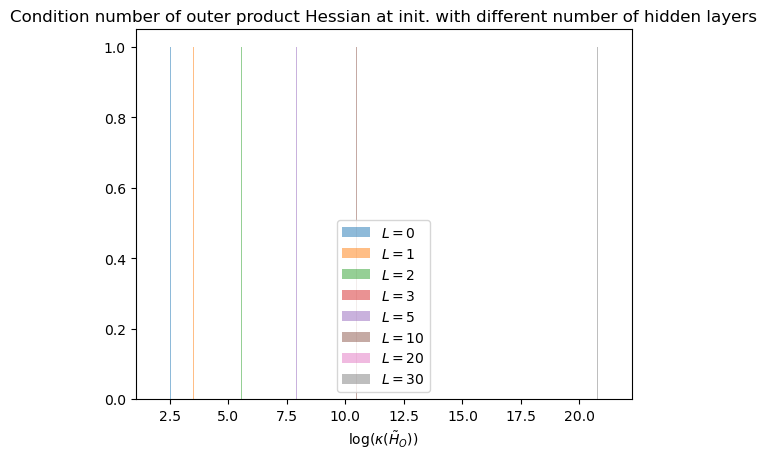

In [6]:
for i in range(len(L)):
    plt.hist(np.log(H_o_tilde_cond_kaiming_noskip_l[i]), alpha=0.5, bins=30, label='$L= %d $' %L[i])


plt.xlabel(f'$\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Condition number of outer product Hessian at init. with different number of hidden layers')
plt.legend()

Text(0.5, 1.0, 'Upper bound of condition number of outer product Hessian at init. with different number of hidden layers (depends on sampled weights)')

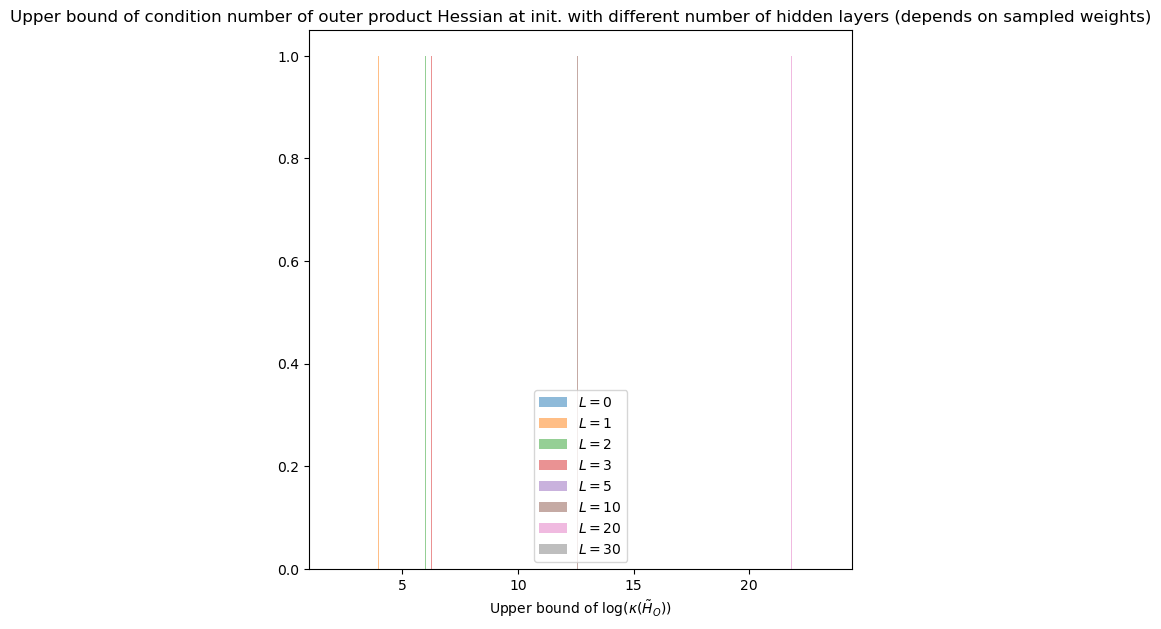

In [7]:
plt.figure(figsize=(7,7))

for i in range(len(L)):
    plt.hist(np.log(H_o_cond_upper_bounds[i]), alpha=0.5, bins=30, label='$L= %d $' %L[i])


plt.legend()

plt.xlabel(f'Upper bound of $\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Upper bound of condition number of outer product Hessian at init. with different number of hidden layers (depends on sampled weights)')


Text(0.5, 1.0, 'Upper bound of condition number of outer product Hessian at init. with different number of hidden layers (depends on sampled weights)')

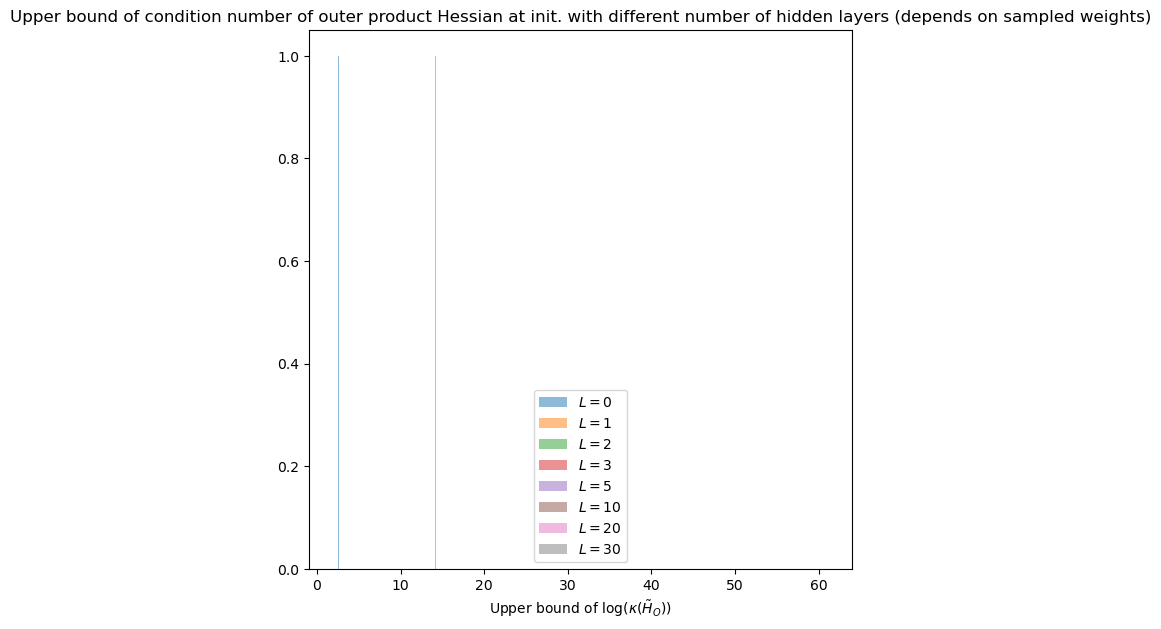

In [8]:
plt.figure(figsize=(7,7))

for i in range(len(L)):
    plt.hist(np.log(H_o_cond_upper_bounds_2[i]), alpha=0.5, bins=30, label='$L= %d $' %L[i])


plt.legend()

plt.xlabel(f'Upper bound of $\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Upper bound of condition number of outer product Hessian at init. with different number of hidden layers (depends on sampled weights)')


In [9]:
print('Average condition number of the outer product Hessian for different number of hidden layers:')

for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})]={np.mean(H_o_tilde_cond_kaiming_noskip_l[i])}$'))

Average condition number of the outer product Hessian for different number of hidden layers:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
print('Average upper bound on condition number based on Eq. (56/57) of the outer product Hessian for different number of hidden layers:')


for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})] \leq {np.mean(H_o_cond_upper_bounds[i])}$'))

Average upper bound on condition number based on Eq. (56/57) of the outer product Hessian for different number of hidden layers:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [11]:
print('Average upper bound on condition number from Eq. (67) of the outer product Hessian for different number of hidden layers:')


for i in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[i]}}})] \leq {np.mean(H_o_cond_upper_bounds_2[i])}$'))

Average upper bound on condition number from Eq. (67) of the outer product Hessian for different number of hidden layers:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, '$\\mathbb{E}[\\kappa(\\tilde{H}_O)$')

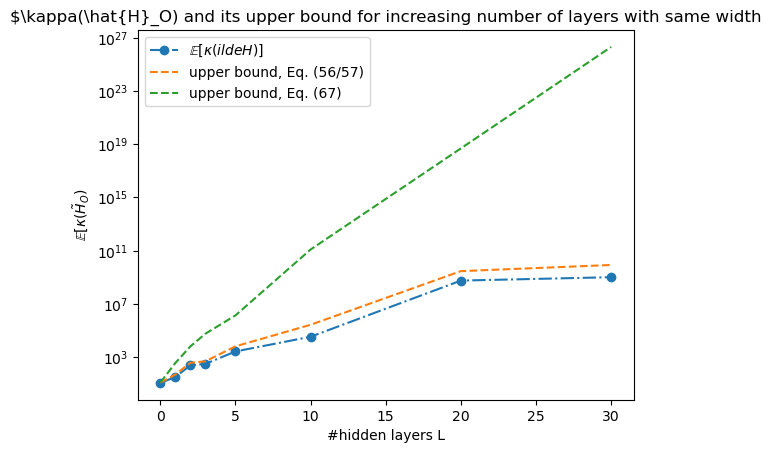

In [12]:
plt.semilogy(L,[np.mean(H_o_tilde_cond_kaiming_noskip_l[i]) for i in range(len(L))],'-.o', label='$\mathbb{{E}}[\kappa(\tilde{H})]$')
plt.semilogy(L,[np.mean(H_o_cond_upper_bounds[i]) for i in range(len(L))],'--', label='upper bound, Eq. (56/57)')
plt.semilogy(L,[np.mean(H_o_cond_upper_bounds_2[i]) for i in range(len(L))],'--', label='upper bound, Eq. (67)')



plt.legend()
plt.title('$\kappa(\hat{H}_O) and its upper bound for increasing number of layers with same width')
plt.xlabel('#hidden layers L')
plt.ylabel(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_O)$')

### L-hidden linear layer: Evaluating the relationship between $m$ and $L$

We observed in the above section that increasing the number of layers while keeping the number of hidden units per layer constant deteriorates the condition number exponentially.

The question now arises, by how much the number of hidden units $m$ per layer have to be increased to compensate for increasing number of layers $L$.

Wide hidden layer: $m > \max\{d,k\}$

#### input covariance $\sum_{i=1}^{n} x_ix_i^T = \Sigma_{xx} = I$

In [91]:
d = 5 # input dimension
m1 = [14, 30, 44, 60, 75, 90, 155, 300] # hidden layer dimension
k = 5 # output dimension

L = [0, 1, 2, 3, 4, 5, 10, 20] # number of hidden layers of dim "m"

num_param = [] # count the number of parameters in the model
Linear_Networks = []

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(L)):
    Linear_Networks.append(Linear_NN(d,m1[l],k,L[l]))
    num_param.append(sum(p.numel() for p in Linear_NN(d,m1[l],k,L[l]).parameters()))

In [92]:
m_cons = [14] * len(L) # hidden layer dimension

num_param_cons = [] # count the number of parameters in the model

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(L)):
    num_param_cons.append(sum(p.numel() for p in Linear_NN(d,m_cons[l],k,L[l]).parameters()))

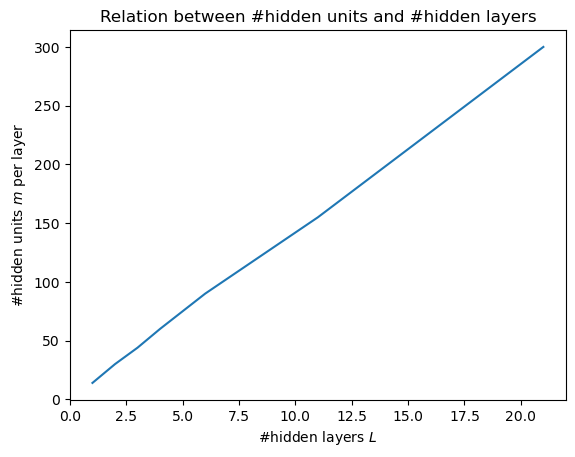

In [93]:
plt.plot(np.array(L)+1, m1)
plt.xlabel('#hidden layers $L$')
plt.ylabel('#hidden units $m$ per layer')
plt.title('Relation between #hidden units and #hidden layers')

plt.savefig('figures/relation_hidden_units_hidden_layers.pdf', bbox_inches='tight')

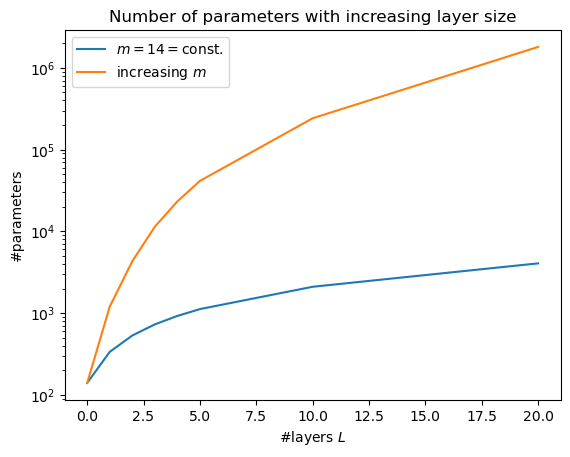

In [95]:
#'Note: For a constant number of hidden units, the number of parameters
#        increases linearly with the number of layers')


plt.semilogy(L,num_param_cons, label='$m=14=$const.')
plt.semilogy(L,num_param, label='increasing $m$')
plt.title('Number of parameters with increasing layer size')
plt.xlabel('#layers $L$')
plt.ylabel('#parameters')
plt.legend()


plt.savefig('figures/num_param_for_increasing_layers_increasing_m.pdf', bbox_inches='tight')

In [96]:
rep = 2000

H_o_tilde_cond_kaiming = []
H_o_cond_upper_bounds = []

cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n

cond_cov_xx = np.linalg.cond(cov_xx)

# do the calculations for each l in L
for l in range(len(L)):
    print('Calculations for L=',L[l])
    # repeat the calculation at initialization for "rep" times
    H_o_tilde_cond_l = []
    
    H_o_tilde_cond_l_upper_bound = []
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks[l].init_weights('kaiming_normal')


        UT_U = torch.zeros((k*d,k*d))
        
        if l == 0:
            V_kaiming = Linear_Networks[l].lin_in.weight
            W_kaiming = Linear_Networks[l].lin_out.weight


            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde.detach()))
        
        else:
            for j in range(1,L[l]+2+1):
                if j == L[l]+2:
                    fac1 = torch.eye(k)
                else:
                    fac1 = Linear_Networks[l].lin_out.weight.detach()

                    for lay in range(-1,-2-L[l]+j,-1):
                        fac1 = fac1 @ Linear_Networks[l].lin_hidden[lay].weight.detach()

                fac1 = fac1 @ fac1.T

                if j == 1:
                    fac2 = torch.eye(d)
                else:
                    fac2 = Linear_Networks[l].lin_in.weight.detach().T

                    for lay in range(j-2):
                        fac2 = fac2 @ Linear_Networks[l].lin_hidden[lay].weight.detach().T

                fac2 = fac2 @ fac2.T

                UT_U += torch.kron(fac1,fac2)



            # calculate the outer Hessian product according to the expression derived by Sidak
            H_o_tilde_l = UT_U @ (torch.kron(torch.eye(k), cov_xx))
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde_l.detach()))
      
    
    H_o_tilde_cond_kaiming.append(H_o_tilde_cond_l)
       


Calculations for L= 0
iter:  0
iter:  1000
Calculations for L= 1
iter:  0
iter:  1000
Calculations for L= 2
iter:  0
iter:  1000
Calculations for L= 3
iter:  0
iter:  1000
Calculations for L= 4
iter:  0
iter:  1000
Calculations for L= 5
iter:  0
iter:  1000
Calculations for L= 10
iter:  0
iter:  1000
Calculations for L= 20
iter:  0
iter:  1000


In [97]:
display(Latex(f'Average condition number of the outer product Hessian for $\kappa(\Sigma) \\approx $ 1'))

print('Averaged over %d individual runs.' % rep)

for l in range(len(L)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[l]}}})]={np.mean(H_o_tilde_cond_kaiming[l])}$'))

<IPython.core.display.Latex object>

Averaged over 2000 individual runs.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

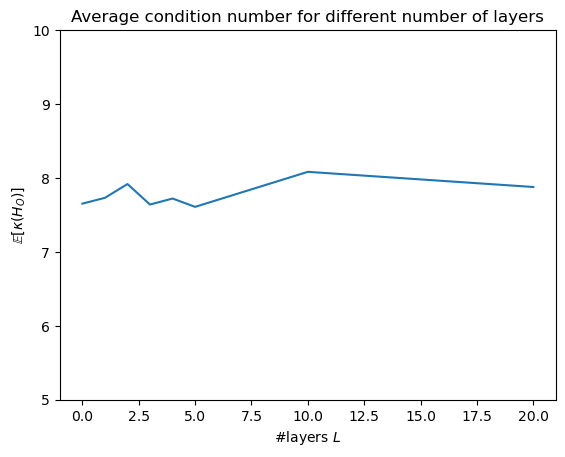

In [102]:
plt.plot(L,[np.mean(H_o_tilde_cond_kaiming[l]) for l in range(len(L))])
plt.ylim([5,10])

plt.xlabel('#layers $L$')
plt.ylabel('$\mathbb{E}[\kappa(H_O)]$')
plt.title('Average condition number for different number of layers')

plt.savefig('figures/avg_cond_num_L_layer_increasing_m.pdf', bbox_inches='tight')

In [103]:
display(Latex(f'Variance of condition number of the outer product Hessian for $\kappa(\Sigma) \\approx $ 1'))

for l in range(len(L)):
    display(Latex(f'${{Var}}[\kappa(\\tilde{{H}}_{{kai,o,L={L[l]}}})]={np.var(H_o_tilde_cond_kaiming[l])}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0.5, 1.0, 'Variance of distribution of condition number for different number of layers')

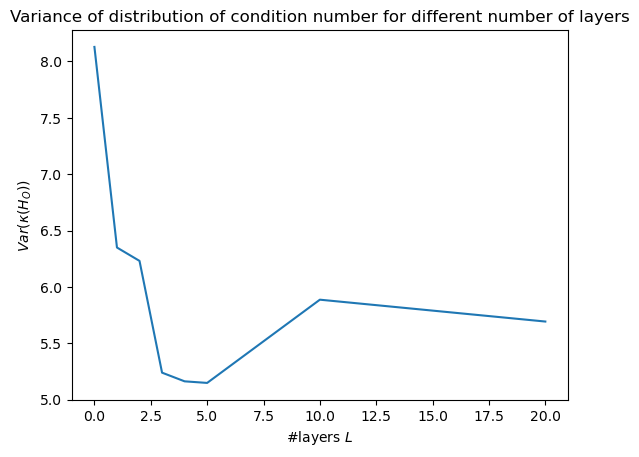

In [104]:
plt.plot(L,[np.var(H_o_tilde_cond_kaiming[l]) for l in range(len(L))])
# plt.ylim([5,10])

plt.xlabel('#layers $L$')
plt.ylabel('$Var(\kappa(H_O))$')
plt.title('Variance of distribution of condition number for different number of layers')

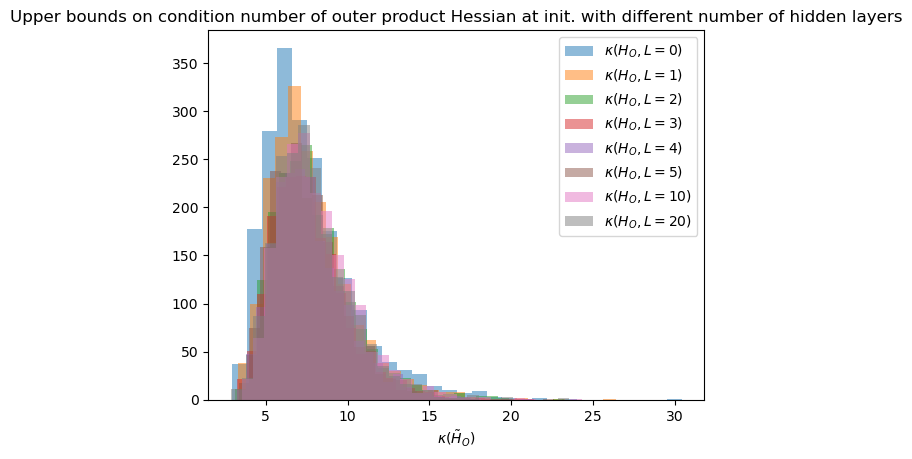

In [105]:
for i in range(len(L)):
    plt.hist(H_o_tilde_cond_kaiming[i], alpha=0.5, bins=30, label='$\kappa(H_O,L= %d)$' % L[i])

plt.xlabel(f'$\kappa(\\tilde{{H}}_O)$')
plt.title(f'Upper bounds on condition number of outer product Hessian at init. with different number of hidden layers')
plt.legend()

plt.savefig('figures/histogram_num_hidden_layers_increasing_m.pdf', bbox_inches='tight')

#####  Debugging the calculation of $\mathbf{U}^T\mathbf{U}$  for few layers by calculating it explicitly

In [4]:
d = 10
L = [0, 1, 2, 3, 5]
NNs = []



for l in L:
    Ws = []
    for i in range(l+2):
        Ws.append(torch.randn(d,d))
    NNs.append(Ws)

In [5]:
cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_d.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n
cond_cov_xx = torch.linalg.cond(cov_xx)

In [6]:
W1 = (NNs[1][-1] @ NNs[1][-2]) @ (NNs[1][-1] @ NNs[1][-2]).T 
W2 = torch.eye(d)

summand1 = torch.kron(W1,W2)


W1 = (NNs[1][-1]) @ NNs[1][-1].T
W2 = (NNs[1][0]).T @ (NNs[1][0])

summand2 = torch.kron(W1,W2)

W1 = torch.eye(d)
W2 = (NNs[1][1] @ NNs[1][0]).T @ (NNs[1][1] @ NNs[1][0])

summand3 = torch.kron(W1,W2)


H_l_3 = (summand1 + summand2 + summand3) @ torch.kron(torch.eye(d), cov_xx)


In [7]:
W1 = (NNs[2][-1] @ NNs[2][-2] @ NNs[2][-3]) @ (NNs[2][-1] @ NNs[2][-2] @ NNs[2][-3]).T 
W2 = torch.eye(d)

summand1 = torch.kron(W1,W2)

W1 = (NNs[2][-1] @ NNs[2][-2]) @ (NNs[2][-1] @ NNs[2][-2]).T  
W2 = NNs[2][0].T @ NNs[2][0]

summand2 = torch.kron(W1,W2)

W1 = (NNs[2][-1]) @ NNs[2][-1].T
W2 = (NNs[2][1] @ NNs[2][0]).T @ (NNs[2][1] @ NNs[2][0])

summand3 = torch.kron(W1,W2)

W1 = torch.eye(d)
W2 = (NNs[2][2] @ NNs[2][1] @ NNs[2][0]).T @ (NNs[2][2] @ NNs[2][1] @ NNs[2][0])

summand4 = torch.kron(W1,W2)


H_l_4 = (summand1 + summand2 + summand3 + summand4) @ torch.kron(torch.eye(d), cov_xx)


In [8]:
W1 = W1 = (NNs[3][-1] @ NNs[3][-2] @ NNs[3][-3] @ NNs[3][-4]) @ (NNs[3][-1] @ NNs[3][-2] @ NNs[3][-3] @ NNs[3][-4]).T 
W2 = torch.eye(d)

summand1 = torch.kron(W1,W2)

W1 = (NNs[3][-1] @ NNs[3][-2] @ NNs[3][-3]) @ (NNs[3][-1] @ NNs[3][-2] @ NNs[3][-3]).T 
W2 = NNs[3][0].T @ NNs[3][0]

summand2 = torch.kron(W1,W2)

W1 = (NNs[3][-1] @ NNs[3][-2]) @ (NNs[3][-1] @ NNs[3][-2]).T  
W2 = (NNs[3][1] @ NNs[3][0]).T @ (NNs[3][1] @ NNs[3][0])

summand3 = torch.kron(W1,W2)

W1 = (NNs[3][-1]) @ NNs[3][-1].T
W2 = (NNs[3][2] @ NNs[3][1] @ NNs[3][0]).T @ (NNs[3][2] @ NNs[3][1] @ NNs[3][0])

summand4 = torch.kron(W1,W2)

W1 = torch.eye(d)
W2 = (NNs[3][3] @ NNs[3][2] @ NNs[3][1] @ NNs[3][0]).T @ (NNs[3][3] @ NNs[3][2] @ NNs[3][1] @ NNs[3][0])

summand5 = torch.kron(W1,W2)


H_l_5 = (summand1 + summand2 + summand3 + summand4 + summand5) @ torch.kron(torch.eye(d), cov_xx)


In [9]:
l=3
for j in range(1,l+2+1): 
    print(j)
    for lay in range(1,l+3-j-2+1):
        print(j,lay)

1
1 1
1 2
1 3
2
2 1
2 2
3
3 1
4
5


In [17]:
l = 2

UT_U = torch.zeros((d*d,d*d))

if l == 0:
    V_kaiming = NNs[l][0]
    W_kaiming = NNs[l][-1]


    # calculate the outer Hessian product according to the expression derived by Sidak
    H_o_tilde = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(d), V_kaiming.T@V_kaiming@cov_xx)
    H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde.detach()))

else:
    for j in range(1,L[l]+2+1):
        print('first j: ', j)
        if j == L[l]+2:
            fac1 = torch.eye(d)
            print('first if, j: ', j)
        else:
            print('first else, j: ', j)
            
            fac1 = NNs[l][-1]

            for lay in range(-2,-2-1-L[l]+j,-1):
                print('first else, j: ', j, 'lay: ', lay)
                
                fac1 = fac1 @ NNs[l][(lay)]

        fac1 = fac1 @ fac1.T

        if j == 1:
            fac2 = torch.eye(d)
            print('second if, j: ', j)
        else:
            print('second else, j: ', j)
            fac2 = NNs[l][0].T

            for lay in range(j-2):
                print('second else, j: ', j, 'lay: ', lay)
                fac2 = fac2 @ NNs[l][lay+1].T

        fac2 = fac2 @ fac2.T

        UT_U += torch.kron(fac1,fac2)



    # calculate the outer Hessian product according to the expression derived by Sidak
    H_o_tilde_l = UT_U @ (torch.kron(torch.eye(d), cov_xx))

first j:  1
first else, j:  1
first else, j:  1 lay:  -2
first else, j:  1 lay:  -3
second if, j:  1
first j:  2
first else, j:  2
first else, j:  2 lay:  -2
second else, j:  2
first j:  3
first else, j:  3
second else, j:  3
second else, j:  3 lay:  0
first j:  4
first if, j:  4
second else, j:  4
second else, j:  4 lay:  0
second else, j:  4 lay:  1


In [18]:
torch.sum(H_l_4-H_o_tilde_l)

tensor(-1.3094e-11)

In [19]:
H_o_tilde_l

tensor([[ 5.5293e+03, -9.3286e+02,  1.5880e+03,  ..., -3.1788e+01,
         -1.0726e+02,  1.3425e+00],
        [-9.2904e+02,  2.2682e+03, -5.0909e+02,  ..., -2.7089e+01,
         -1.4061e+01,  1.1029e+02],
        [ 1.5955e+03, -5.4095e+02,  2.7707e+03,  ...,  9.5652e+01,
          3.0556e+02,  2.1017e+02],
        ...,
        [-3.7527e+01, -2.2588e+01,  9.9923e+01,  ...,  2.0147e+03,
          6.2509e+02, -6.0216e+02],
        [-1.0875e+02, -1.8310e+01,  3.0652e+02,  ...,  6.0897e+02,
          3.5865e+03,  1.6125e+02],
        [-7.9328e+00,  1.0090e+02,  2.0972e+02,  ..., -6.1112e+02,
          1.6832e+02,  4.4287e+03]])

In [20]:
H_l_4

tensor([[ 5.5293e+03, -9.3286e+02,  1.5880e+03,  ..., -3.1788e+01,
         -1.0726e+02,  1.3425e+00],
        [-9.2904e+02,  2.2682e+03, -5.0909e+02,  ..., -2.7089e+01,
         -1.4061e+01,  1.1029e+02],
        [ 1.5955e+03, -5.4095e+02,  2.7707e+03,  ...,  9.5652e+01,
          3.0556e+02,  2.1017e+02],
        ...,
        [-3.7527e+01, -2.2588e+01,  9.9923e+01,  ...,  2.0147e+03,
          6.2509e+02, -6.0216e+02],
        [-1.0875e+02, -1.8310e+01,  3.0652e+02,  ...,  6.0897e+02,
          3.5865e+03,  1.6125e+02],
        [-7.9328e+00,  1.0090e+02,  2.0972e+02,  ..., -6.1112e+02,
          1.6832e+02,  4.4287e+03]])

In [21]:
torch.linalg.cond(H_l_4)

tensor(10778013.6610)

In [22]:
torch.linalg.cond(H_o_tilde_l)

tensor(10778013.6603)

### Playing a bit around with linear NN where the hidden layers have different number of units

In [85]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class Linear_NN_varying_hidden_units(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: array of hidden layer dimensions of length L+1
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.lin_out = nn.Linear(m[-1], k, bias=False)
        self.lin_in = nn.Linear(d, m[0], bias=False)
        
        self.lin_hidden = nn.ModuleList()
        for i in range(self.L):
            self.lin_hidden.append(nn.Linear(m[i], m[i+1], bias=False))
#         self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        
    def forward(self, xb):
        xb = self.lin_in(xb)
        
        for i in range(self.L):
            xb = self.lin_hidden[i](xb)
            
        xb = self.lin_out(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

In [86]:
L = [3]
d = 5
k = 5
m = [9, 12, 14, 17]

lin_NN = Linear_NN_varying_hidden_units(d,m,k,L[0])

sum(p.numel() for p in lin_NN.parameters())

644

In [87]:
lin_NN

Linear_NN_varying_hidden_units(
  (lin_out): Linear(in_features=17, out_features=5, bias=False)
  (lin_in): Linear(in_features=5, out_features=9, bias=False)
  (lin_hidden): ModuleList(
    (0): Linear(in_features=9, out_features=12, bias=False)
    (1): Linear(in_features=12, out_features=14, bias=False)
    (2): Linear(in_features=14, out_features=17, bias=False)
  )
)

In [81]:
rep = 2000

H_o_tilde_cond_kaiming_noskip_l = []

H_o_cond_upper_bounds = []
H_o_cond_upper_bounds_2 = []



cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n
cond_cov_xx = torch.linalg.cond(cov_xx)

# do the calculations for each linear NN
for l in range(len(L)):
    # repeat the calculation at initialization for 'rep' times
    H_o_tilde_cond_l = []
    H_o_tilde_cond_l_upper_bound = []
    H_o_tilde_cond_l_upper_bound_2 = []
    
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        lin_NN.init_weights('kaiming_normal')
        
        
    # calculate the theoretical upper bound of the condition number of outer product Hessian 
    # based on the first approximation Eq. (56/57)
        lam_max_upperb = 0
        lam_min_lowerb = 0
        
        for el in range(1,L[l]+2+1):
            if el == L[l]+2:
                W_1 = torch.eye(k) 
            else:
                W_1 = lin_NN.lin_out.weight.detach()
            
                for lay in range(-1,-2-L[l]+el,-1):
                    W_1 = W_1 @ lin_NN.lin_hidden[lay].weight.detach()
            
            if el == 1:
                W_2 = torch.eye(d)
            else:
                W_2 = lin_NN.lin_in.weight.detach().T
                
                for lay in range(el-2):
                    W_2 = W_2 @ lin_NN.lin_hidden[lay].weight.detach().T
            
            lam_max_upperb += torch.linalg.eigvalsh(W_1 @ W_1.T)[-1] * torch.linalg.eigvalsh(W_2 @ W_2.T)[-1]
            lam_min_lowerb += torch.linalg.eigvalsh(W_1 @ W_1.T)[0] * torch.linalg.eigvalsh(W_2 @ W_2.T)[0]            
            
        H_o_tilde_upper_b = ((lam_max_upperb)/(lam_min_lowerb)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound.append(H_o_tilde_upper_b)    
        
        
        
                
    # calculate the theoretical upper bound of the condition number of outer product Hessian 
    # based on the second approximation Eq. (67)
        H_o_tilde_upper_b_2 = torch.linalg.cond( lin_NN.lin_in.weight.detach() )**2 \
                        * torch.linalg.cond( lin_NN.lin_out.weight.detach() )**2
        
        nominator = (1/(torch.linalg.svdvals( lin_NN.lin_in.weight.detach() )[0]**2 )) \
                    + (1/(torch.linalg.svdvals( lin_NN.lin_out.weight.detach() )[0]**2))
        denominator = (1/(torch.linalg.svdvals( lin_NN.lin_in.weight.detach() )[-1]**2)) \
                    + (1/(torch.linalg.svdvals( lin_NN.lin_out.weight.detach() )[-1]**2))
       
        for lay in range(L[l]):
            H_o_tilde_upper_b_2 *= (torch.linalg.svdvals( lin_NN.lin_hidden[lay].weight.detach() )[0] / \
                             torch.linalg.svdvals( lin_NN.lin_hidden[lay].weight.detach() )[min(d,k)] )**2
            nominator += torch.linalg.svdvals( lin_NN.lin_hidden[lay].weight.detach())[0]**2
            denominator += torch.linalg.svdvals( lin_NN.lin_hidden[lay].weight.detach())[min(d,k)]**2
                        
        H_o_tilde_upper_b_2 *= ((nominator)/(denominator)) * cond_cov_xx
        H_o_tilde_cond_l_upper_bound_2.append(H_o_tilde_upper_b_2)
        
        


    # calculate the outer Hessian product according to the expression derived by Sidak (Eq. 2)
        UT_U = torch.zeros((k*d,k*d))
        
        if L[l] == 0:
            V_kaiming = lin_NN.lin_in.weight.detach()
            W_kaiming = lin_NN.lin_out.weight.detach()


            
            H_o_tilde = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde))
        

        else: 
            for j in range(1,L[l]+2+1):
                if j == L[l]+2:
                    fac1 = torch.eye(k)
                else:
                    fac1 = lin_NN.lin_out.weight.detach()
                    
                    for lay in range(-1,-2-L[l]+j,-1):
                        fac1 = fac1 @ lin_NN.lin_hidden[lay].weight.detach()

                fac1 = fac1 @ fac1.T

                if j == 1:
                    fac2 = torch.eye(d)
                else:
                    fac2 = lin_NN.lin_in.weight.detach().T

                    for lay in range(j-2):
                        fac2 = fac2 @ lin_NN.lin_hidden[lay].weight.detach().T

                fac2 = fac2 @ fac2.T

                UT_U += torch.kron(fac1,fac2)

            H_o_tilde_l = UT_U @ (torch.kron(torch.eye(k), cov_xx))
            H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde_l.detach()))
      
    
    
    H_o_tilde_cond_kaiming_noskip_l.append(H_o_tilde_cond_l)
    H_o_cond_upper_bounds.append(H_o_tilde_cond_l_upper_bound)
    H_o_cond_upper_bounds_2.append(H_o_tilde_cond_l_upper_bound_2)

    
       


iter:  0
iter:  1000


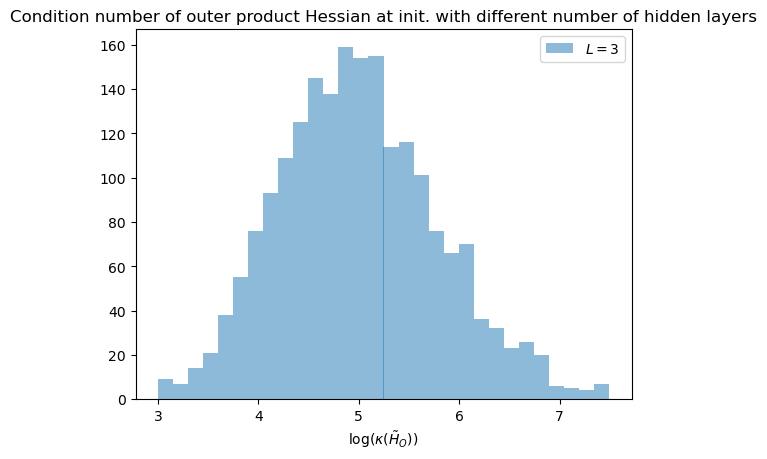

In [84]:
for i in range(len(L)):
    plt.hist(np.log(H_o_tilde_cond_kaiming_noskip_l[i]), alpha=0.5, bins=30, label='$L= %d $' %L[i])


plt.xlabel(f'$\\log(\kappa(\\tilde{{H}}_O))$')
plt.title(f'Condition number of outer product Hessian at init. with different number of hidden layers')
plt.legend()

In [83]:
np.mean(H_o_tilde_cond_kaiming_noskip_l[i])

206.53936161532943